In [5]:
import pandas as pd

# Load full quantum features
df = pd.read_csv("mci_features_quantum_5qbit.csv")

print(f"✅ Loaded full quantum features: {df.shape[1]} columns.")

✅ Loaded full quantum features: 33 columns.


In [6]:
print(df["Label"].value_counts())
print(df["Label"].unique())

Label
Healthy    71880
MCI        65890
Name: count, dtype: int64
['Healthy' 'MCI']


In [7]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    axs[0].plot(history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[0].set_title(f"Model Accuracy - {title}")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Loss Plot
    axs[1].plot(history.history['loss'], label="Train Loss")
    axs[1].plot(history.history['val_loss'], label="Validation Loss")
    axs[1].set_title(f"Model Loss - {title}")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()

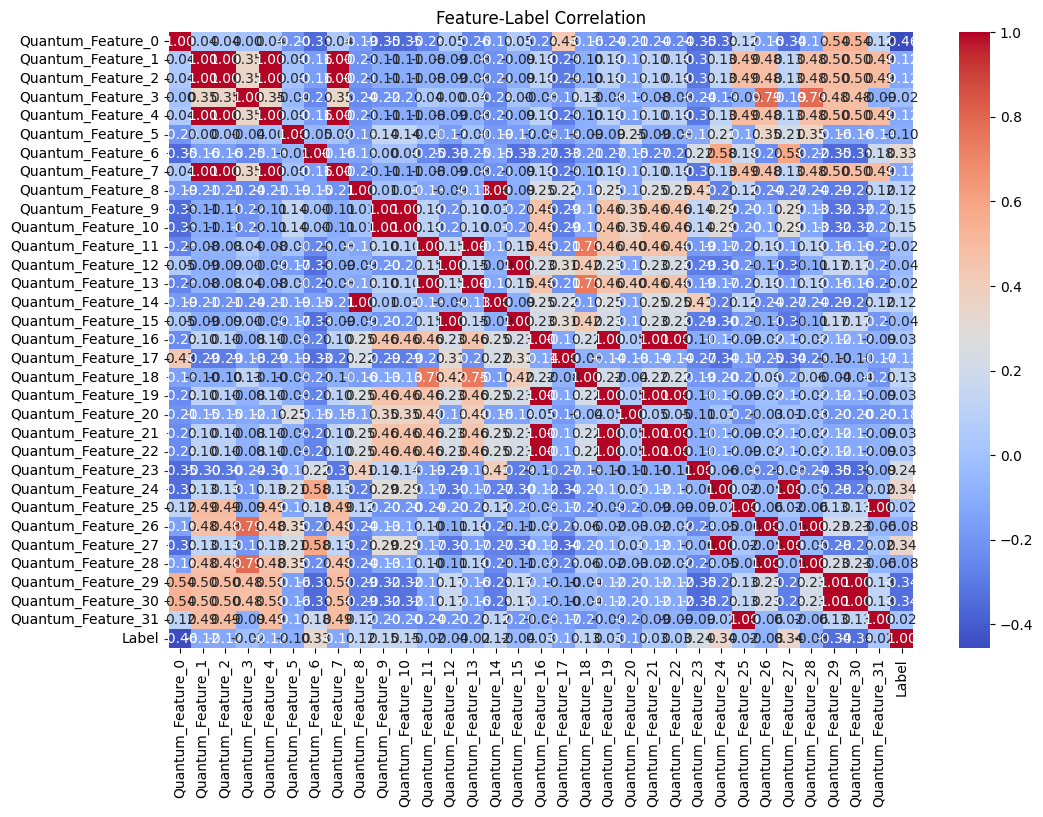

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df["Label"] = df["Label"].map({"Healthy": 0, "MCI": 1})

df_corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature-Label Correlation")
plt.show()

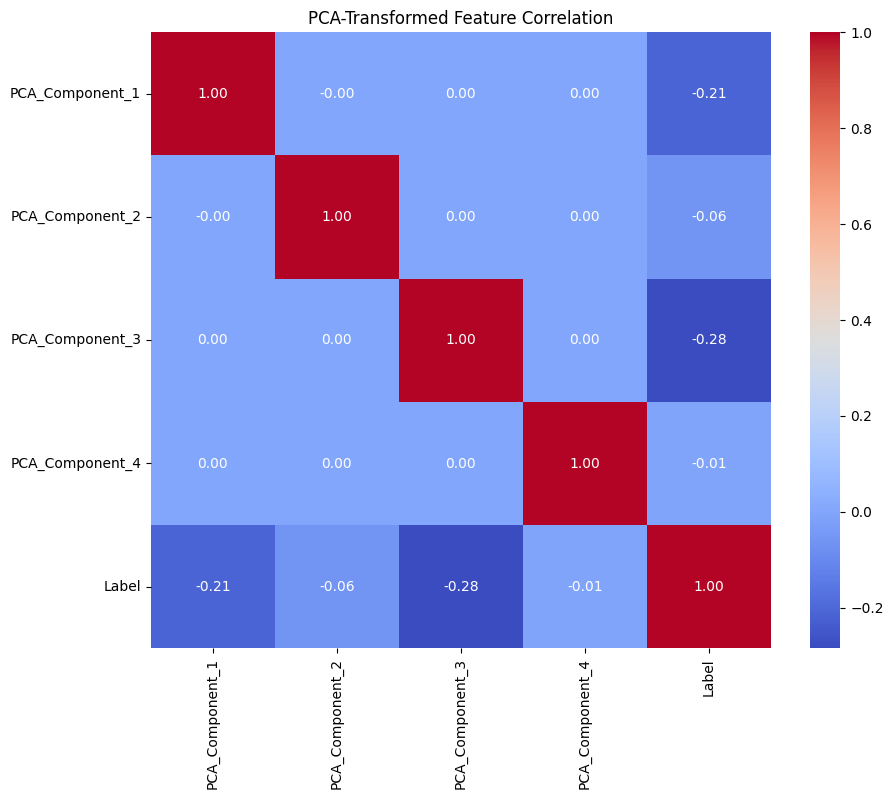

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ensure features and labels are correctly extracted
X = df.drop(columns=["Label"]).values  # Features
y = df["Label"].values  # Labels

# 🔹 Step 3: Standardize features before PCA (ensures equal weighting)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Step 4: Apply PCA to transform features while keeping the same count
pca = PCA(n_components=4)  # Keep 4 components (since you had 4 after dropping correlations)
X_pca = pca.fit_transform(X_scaled)

# 🔹 Step 5: Convert PCA-transformed features into a DataFrame
pca_feature_names = [f"PCA_Component_{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_feature_names)
df_pca["Label"] = y  # Reattach the labels

# 🔹 Step 6: Compute and visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_pca.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PCA-Transformed Feature Correlation")
plt.show()

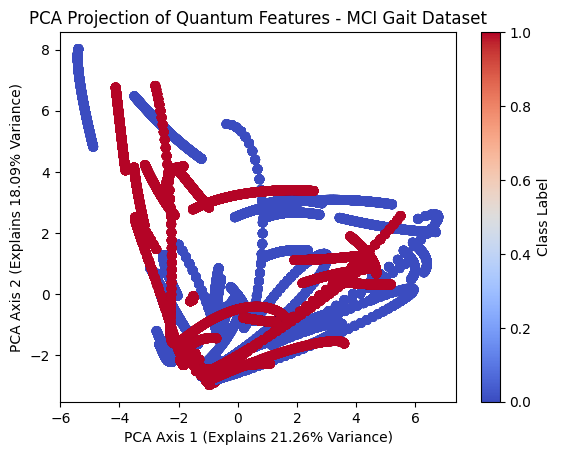

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm")
plt.xlabel("PCA Axis 1 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PCA Axis 2 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[1] * 100))
plt.title("PCA Projection of Quantum Features - MCI Gait Dataset")
plt.colorbar(label="Class Label")
plt.show()

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

tf.keras.backend.set_floatx('float32')

# ✅ Convert labels to one-hot encoding
num_classes = 2  # Adjust for your dataset
y_onehot = to_categorical(y, num_classes=num_classes)

# ✅ Split into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_onehot, test_size=0.2, random_state=42)


In [12]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [13]:
# Sequential model (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, clipvalue=0.5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/30
3445/3445 [==============================] - 17s 4ms/step - loss: 0.3659 - accuracy: 0.8309 - val_loss: 0.1775 - val_accuracy: 0.9361
Epoch 2/30
3445/3445 [==============================] - 14s 4ms/step - loss: 0.1249 - accuracy: 0.9517 - val_loss: 0.0951 - val_accuracy: 0.9615
Epoch 3/30
3445/3445 [==============================] - 17s 5ms/step - loss: 0.0823 - accuracy: 0.9660 - val_loss: 0.0780 - val_accuracy: 0.9679
Epoch 4/30
3445/3445 [==============================] - 17s 5ms/step - loss: 0.0659 - accuracy: 0.9726 - val_loss: 0.0658 - val_accuracy: 0.9708
Epoch 5/30
3445/3445 [==============================] - 17s 5ms/step - loss: 0.0565 - accuracy: 0.9764 - val_loss: 0.0521 - val_accuracy: 0.9777
Epoch 6/30
3445/3445 [==============================] - 18s 5ms/step - loss: 0.0505 - accuracy: 0.9787 - val_loss: 0.0469 - val_accuracy: 0.9810
Epoch 7/30
3445/3445 [==============================] - 19s 5ms/step - loss: 0.0460 - accuracy: 0.9807 - val_loss: 0.0475 - val_ac

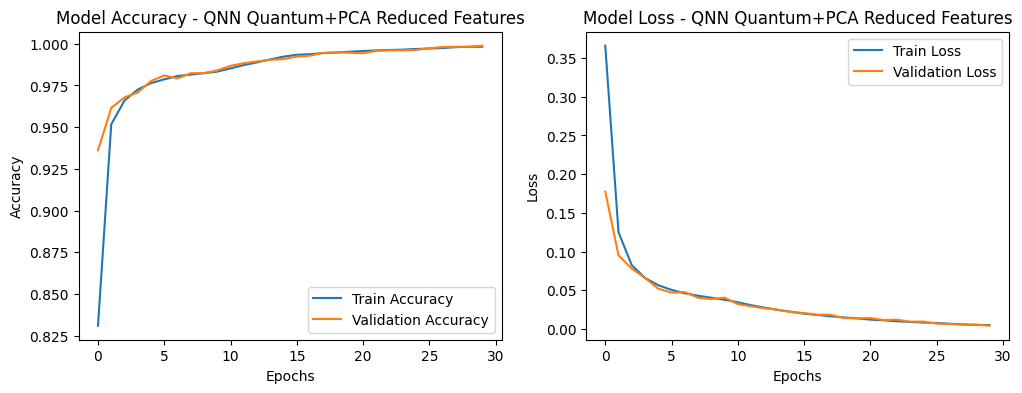

In [14]:
plot_history(history, "QNN Quantum+PCA Reduced Features")

In [15]:
# ✅ Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"QNN Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

862/862 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 0.9988
QNN Test Accuracy: 0.9988 | Loss: 0.0042


862/862 [==============================] - 2s 1ms/step


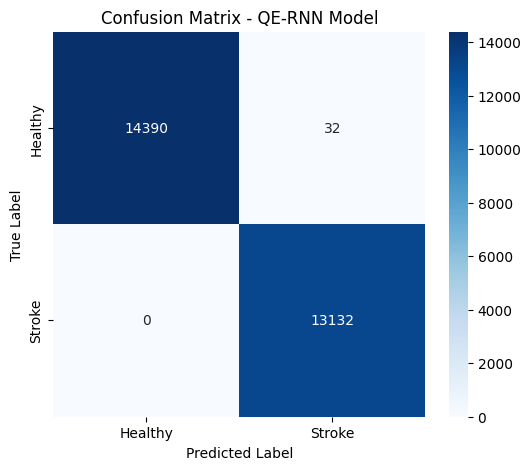

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14422
           1       1.00      1.00      1.00     13132

    accuracy                           1.00     27554
   macro avg       1.00      1.00      1.00     27554
weighted avg       1.00      1.00      1.00     27554



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 🔹 Step 1: Get Model Predictions
y_pred_probs = model.predict(X_test)  # Get prediction probabilities


# 🔹 Step 2: Adjust Decision Threshold
threshold = 0.5
y_pred = (y_pred_probs[:, 0] > threshold).astype(int)

# 🔹 Step 3: Convert one-hot encoded labels (if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check safely
    y_test = np.argmax(y_test, axis=1)  # Converts one-hot labels back to single-class


# 🔹 Step 4: Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 🔹 Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Stroke"], yticklabels=["Healthy", "Stroke"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - QE-RNN Model")
plt.show()

# 🔹 Step 6: Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [17]:
model.save("qbai.h5")

# Confidence Check

In [18]:
import numpy as np

# Get model predictions
y_pred_probs = model.predict(X_test)

# Check confidence distribution
print("Min Confidence:", np.min(y_pred_probs))
print("Max Confidence:", np.max(y_pred_probs))
print("Mean Confidence:", np.mean(y_pred_probs))

862/862 [==============================] - 1s 2ms/step
Min Confidence: 1.3868571e-18
Max Confidence: 1.0
Mean Confidence: 0.47680056


862/862 [==============================] - 1s 1ms/step


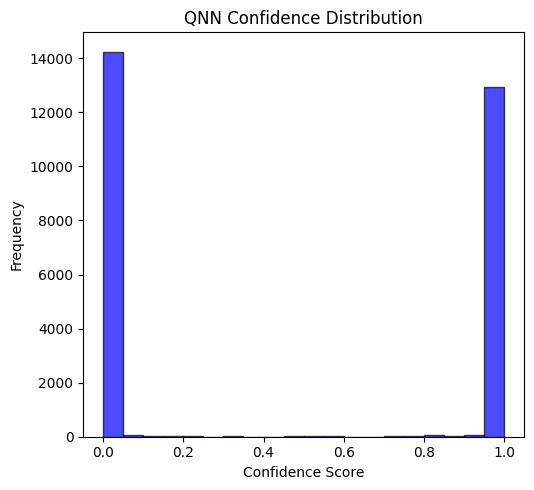

In [19]:
y_true_qnn = y_test# Convert one-hot labels to class labels
y_pred_qnn = np.argmax(model.predict(X_test), axis=1)
confidences_qnn = np.max(model.predict(X_test), axis=1)

# Convert to numpy arrays if needed
qnn_confidences = np.array(confidences_qnn)  # Replace with your QNN confidence list

plt.figure(figsize=(10, 5))

# QNN Confidence Distribution
plt.subplot(1, 2, 1)
plt.hist(qnn_confidences, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("QNN Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Data Leak Check

In [20]:
from sklearn.utils import shuffle

X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)
leakage_model = tf.keras.models.clone_model(model)
leakage_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
leakage_model.fit(X_train_shuffled, y_train_shuffled, epochs=10, batch_size=64, verbose=1)
leakage_loss, leakage_acc = leakage_model.evaluate(X_test, y_test)

print(f'Leakage Test Accuracy: {leakage_acc:.4f} (should be ~0.50 for a valid test)')

Epoch 1/10


c:\Users\basma\OneDrive\Documents\THESIS\QML\.venv\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1723/1723 [==============================] - 9s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5214
Epoch 2/10
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 3/10
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 4/10
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 5/10
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 6/10
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 7/10
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 8/10
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 9/10
1723/1723 [==============================] - 9s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5213
Epoch 10/10
862/862 [==============================] - 2

# K-Fold

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define number of folds
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Placeholder for epoch-wise averaging
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold+1}/{k}")

    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Define LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, clipvalue=0.5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    # Train model
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=1)

    # Store per-epoch results
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate model
    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")


Training Fold 1/5
Epoch 1/20
2756/2756 [==============================] - 17s 5ms/step - loss: 0.3994 - accuracy: 0.8118 - val_loss: 0.2021 - val_accuracy: 0.9134
Epoch 2/20
2756/2756 [==============================] - 13s 5ms/step - loss: 0.1655 - accuracy: 0.9273 - val_loss: 0.1324 - val_accuracy: 0.9481
Epoch 3/20
2756/2756 [==============================] - 13s 5ms/step - loss: 0.1152 - accuracy: 0.9519 - val_loss: 0.0957 - val_accuracy: 0.9614
Epoch 4/20
2756/2756 [==============================] - 13s 5ms/step - loss: 0.0876 - accuracy: 0.9648 - val_loss: 0.0772 - val_accuracy: 0.9689
Epoch 5/20
2756/2756 [==============================] - 14s 5ms/step - loss: 0.0710 - accuracy: 0.9710 - val_loss: 0.0628 - val_accuracy: 0.9760
Epoch 6/20
2756/2756 [==============================] - 13s 5ms/step - loss: 0.0630 - accuracy: 0.9740 - val_loss: 0.0599 - val_accuracy: 0.9756
Epoch 7/20
2756/2756 [==============================] - 11s 4ms/step - loss: 0.0571 - accuracy: 0.9768 - val_lo


Final K-Fold Accuracy: 0.9936


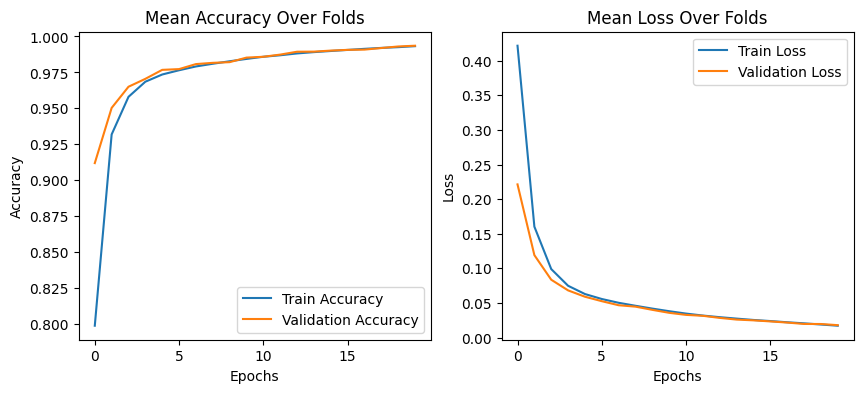

In [22]:
# Convert lists to NumPy arrays for easy averaging
train_accuracies = np.array(train_accuracies)
val_accuracies = np.array(val_accuracies)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Compute mean accuracy/loss across folds
mean_train_acc = np.mean(train_accuracies, axis=0)
mean_val_acc = np.mean(val_accuracies, axis=0)
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# 🎯 Final mean accuracy across folds
final_accuracy = np.mean(val_accuracies[:, -1])
print(f"\nFinal K-Fold Accuracy: {final_accuracy:.4f}")

# 📊 Plot Accuracy Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, label='Train Accuracy')
plt.plot(mean_val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy Over Folds")
plt.legend()

# 📊 Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, label='Train Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mean Loss Over Folds")
plt.legend()

plt.show()

In [23]:
# Convert lists to numpy arrays
folds = list(range(1, len(train_accuracies) + 1))

# Create DataFrame with results per fold
df_results = pd.DataFrame({
    'Fold': folds,
    'Final Train Accuracy': [train_acc[-1] for train_acc in train_accuracies],
    'Final Validation Accuracy': [val_acc[-1] for val_acc in val_accuracies],
    'Final Train Loss': [train_loss[-1] for train_loss in train_losses],
    'Final Validation Loss': [val_loss[-1] for val_loss in val_losses]
})

# Print results
print("\n📊 K-Fold Cross-Validation Results:\n")
print(df_results)

# Compute summary statistics (mean & std deviation)
df_summary = df_results.describe().loc[['mean', 'std']]
print("\n📌 Summary Statistics (Mean & Std Deviation):\n")
print(df_summary)


📊 K-Fold Cross-Validation Results:

   Fold  Final Train Accuracy  Final Validation Accuracy  Final Train Loss  \
0     1              0.984553                   0.985438          0.033478   
1     2              0.997278                   0.998730          0.007175   
2     3              0.994295                   0.992424          0.017026   
3     4              0.994023                   0.994738          0.016794   
4     5              0.996099                   0.996461          0.010789   

   Final Validation Loss  
0               0.032138  
1               0.004503  
2               0.022027  
3               0.019725  
4               0.010876  

📌 Summary Statistics (Mean & Std Deviation):

          Fold  Final Train Accuracy  Final Validation Accuracy  \
mean  3.000000              0.993250                   0.993558   
std   1.581139              0.005042                   0.005094   

      Final Train Loss  Final Validation Loss  
mean          0.017053             